In [3]:
import scipy.stats
import torch
import numpy as np
from tqdm import tqdm
from scipy.stats.distributions import chi2
from scipy.stats import pearsonr
import pickle

import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns
import random
import matplotlib.animation as animation
import sys, os

from utils.plots import *
from utils.funcs import *


from boltzmann_machines.RTRBM import RTRBM
from boltzmann_machines.RTRBM_no_bias import RTRBM_nobias
from boltzmann_machines.RBM import RBM

from data.load_data import *
from data.mock_data import *
from data.reshape_data import *

In [4]:
# Parameters:

N_V = 20
T = 30
N_H = 3
device = 'cpu'
n_rtrbms = 5
n_batches = 500

In [5]:
sparsity = np.arange(0, .9, .1, dtype=np.float32)
W_list = []
generated = []
trained = []

for _ in range(n_rtrbms):
    W = 2 * np.random.rand(N_H, N_V) - 1
    U = 2 * np.random.rand(N_H, N_H) - 1
    for sp in sparsity:
        idx = np.random.randint(low=0, high=int(N_V*N_H), size=(int(sp*N_V*N_H),))
        for x,y in zip(np.unravel_index(idx, W.shape)[0], np.unravel_index(idx, W.shape)[1]):
            W[x, y] = 0
        W_list += [torch.tensor(W, device=device)]

        b_init = torch.zeros(1, N_H, dtype=torch.float)
        b_V = torch.zeros(1, N_V, dtype=torch.float)
        b_H = torch.zeros(1, N_H, dtype=torch.float)

        data = torch.zeros(N_V, T, dtype=torch.float)

        rtrbm = RTRBM(data, N_H=N_H, device='cpu')

        rtrbm.W = torch.tensor(W, device=device, dtype=torch.float)
        rtrbm.U = torch.tensor(U, device=device, dtype=torch.float)
        rtrbm.b_init = b_init
        rtrbm.b_V = b_V
        rtrbm.b_H = b_H

        data = torch.zeros(N_V, T, n_batches)
        rt = torch.zeros(N_H, T, n_batches)
        for batch in tqdm(range(n_batches)):
            v_start = (torch.rand(N_V) > 0.2)*1.0
            data[:, :, batch], rt[:, :, batch] = rtrbm.sample(v_start.type(torch.float), chain=T, pre_gibbs_k=100, gibbs_k=100, mode=1, disable_tqdm=True)

        rtrbm_nobias = RTRBM_nobias(data, N_H=N_H, device='cpu')
        rtrbm_nobias.learn(n_epochs=2000, lr=1e-3, lr_end=1e-5, start_decay=200, batchsize=100, mom=0.9, wc=0.0002)

        generated += [rtrbm]
        trained += [rtrbm_nobias]


100%|██████████| 2000/2000 [36:27<00:00,  1.09s/it]


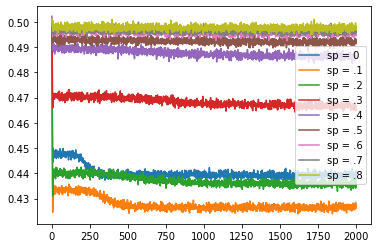

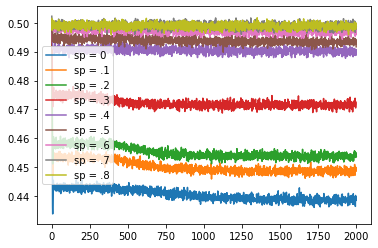

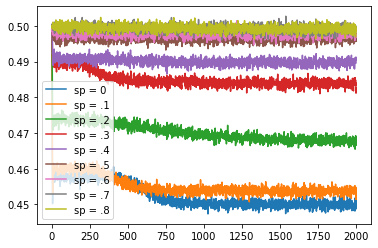

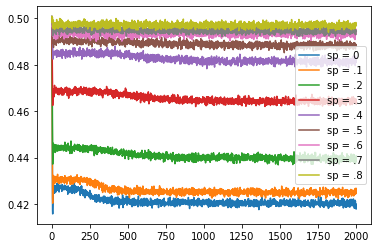

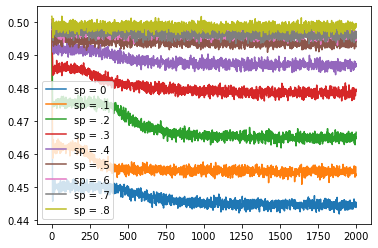

In [18]:
for i in range(45):
    plt.plot(trained[i].errors)
    if (i + 1) % 9 == 0:
        plt.legend(['sp = 0', 'sp = .1', 'sp = .2', 'sp = .3', 'sp = .4', 'sp = .5', 'sp = .6', 'sp = .7', 'sp = .8', 'sp = .9'])
        plt.title('')
        plt.show()

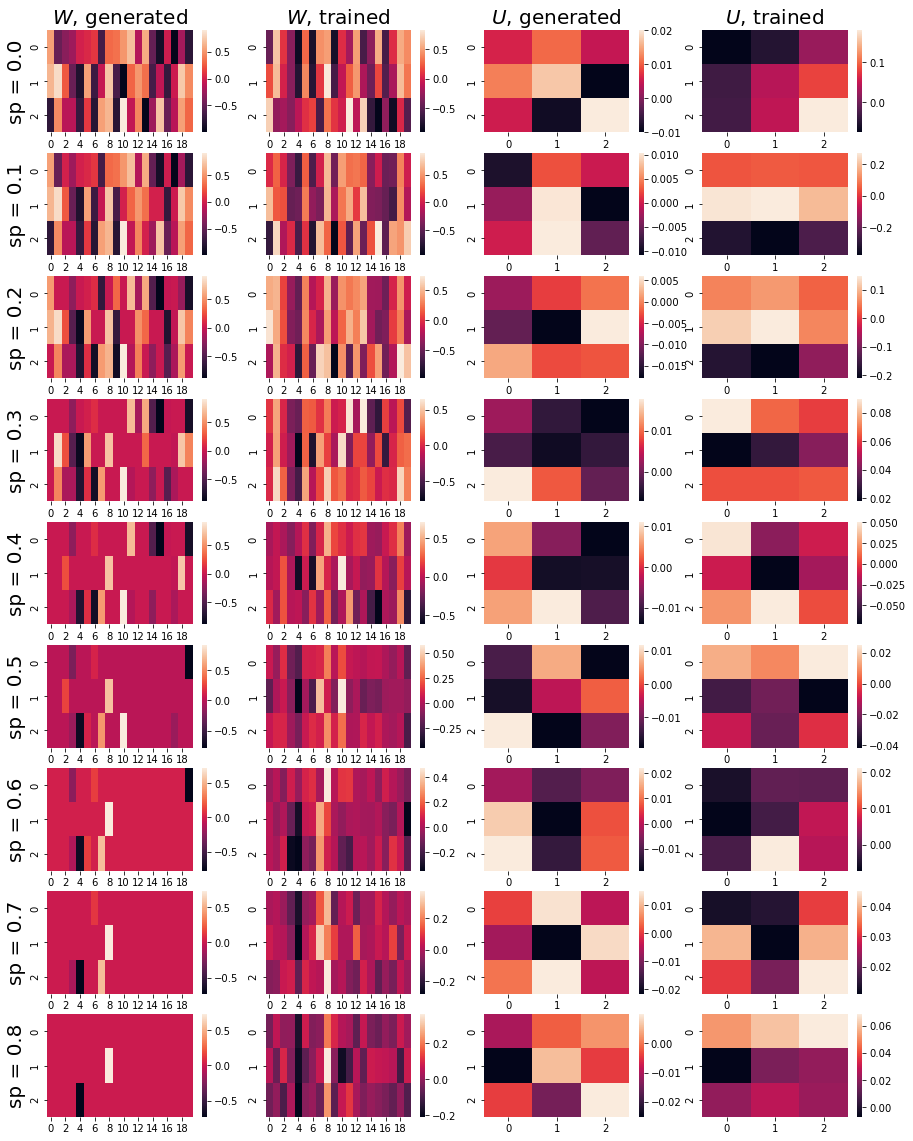

In [103]:
fig, axes = plt.subplots(9, 4, figsize=(15, 20))

for i, ax in enumerate(axes):
    sns.heatmap(generated[i].W, ax=ax[0])
    sns.heatmap(trained[i].W, ax=ax[1])
    sns.heatmap(generated[i].W_acc, ax=ax[2])
    sns.heatmap(trained[i].W_acc, ax=ax[3])
    if i == 0 :
        ax[0].set_title('$W$, generated', fontsize=20)
        ax[1].set_title('$W$, trained', fontsize=20)
        ax[2].set_title('$U$, generated', fontsize=20)
        ax[3].set_title('$U$, trained', fontsize=20)

    ax[0].set_ylabel('sp = %.1f' %(sparsity[i]), fontsize=20)

In [12]:
import scipy

In [113]:

shuffle_idx_possibilities = [[0, 1, 2], [0, 2, 1], [1, 2, 0], [1, 0, 2], [2, 1, 0], [2, 0, 1]]
W_pearson = torch.zeros(len(sparsity), n_rtrbms, len(shuffle_idx_possibilities))
U_pearson = torch.zeros(len(sparsity), n_rtrbms, len(shuffle_idx_possibilities))

W_error = torch.zeros(len(sparsity), n_rtrbms, len(shuffle_idx_possibilities))
U_error = torch.zeros(len(sparsity), n_rtrbms, len(shuffle_idx_possibilities))

for n in range(n_rtrbms):
    for i in range(len(sparsity)):
        U_generated = generated[n * 5 + i].W_acc.clone().detach()
        W_generated = generated[n * 5 + i].W.clone().detach()
        W_trained = trained[n * 5 + i].W.clone().detach()
        U_trained = trained[n * 5 + i].W_acc.clone().detach()

        for j, shuffle_idx in enumerate(shuffle_idx_possibilities):
            W_trained_shuffled = W_trained[shuffle_idx, :]
            U_trained_shuffled = U_trained[shuffle_idx, :]
            U_trained_shuffled = U_trained_shuffled[:, shuffle_idx]

            W_pearson[i, n, j], _ = scipy.stats.pearsonr(W_trained_shuffled.ravel(), W_generated.ravel())
            U_pearson[i, n, j], _ = scipy.stats.pearsonr(U_trained_shuffled.ravel(), U_generated.ravel())

            W_error[i, n, j] = RMSE(W_trained_shuffled, W_generated)
            U_error[i, n, j] = RMSE(U_trained_shuffled, U_generated)

To check whether we found the correct shuffled indexes, We map out the maximum value of the pearson correlation and the minimal value of reconstruction (RMSE) error and check if these overlap.

Text(0.5, 1.0, 'RMSE')

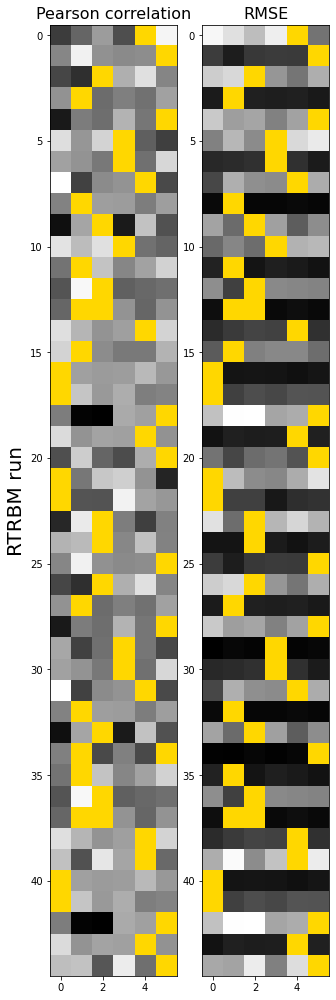

In [114]:
pearsons = W_pearson.reshape((45, 6))
errors = W_error.reshape((45, 6))
max_reshaped_pearsons, _ = torch.max(pearsons, 1)
min_reshaped_errors, _ = torch.min(errors, 1)

pearson_masked = np.ma.masked_where(pearsons == max_reshaped_pearsons.unsqueeze(1), pearsons)
error_masked = np.ma.masked_where(errors == min_reshaped_errors.unsqueeze(1), errors)

fig, axes = plt.subplots(1, 2, figsize=(5,20))
palette = plt.cm.gray.copy()
palette.set_bad('gold')
axes[0].imshow(pearson_masked, cmap=palette)
axes[1].imshow(error_masked, cmap=palette)
axes[0].set_ylabel('RTRBM run', fontsize=20)
axes[0].set_title('Pearson correlation', fontsize=16)
axes[1].set_title('RMSE', fontsize=16)

tensor(1)


Text(0.5, 1.0, 'RMSE ($W$)')

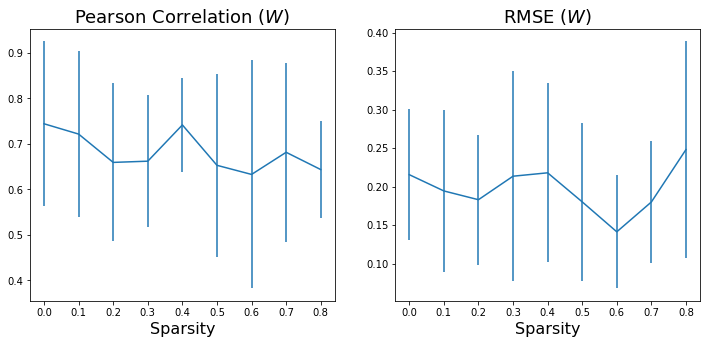

In [127]:
W_pearson_best, best_idx1 = torch.max(W_pearson, 2)
U_pearson_best, _ = torch.max(U_pearson, 2)
W_error_best, best_idx2 = torch.min(W_error, 2)
U_error_best, _ = torch.min(U_error, 2)
print(torch.sum(best_idx1 != best_idx2))

W_pearson_mean = torch.mean(W_pearson_best, 1)
U_pearson_mean = torch.mean(U_pearson_best, 1)
W_error_mean = torch.mean(W_error_best, 1)
U_error_mean = torch.mean(U_error_best, 1)
W_pearson_std = torch.std(W_pearson_best, 1)
U_pearson_std = torch.std(U_pearson_best, 1)
W_error_std = torch.std(W_error_best, 1)
U_error_std = torch.std(U_error_best, 1)


fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].errorbar(sparsity, W_pearson_mean, W_pearson_std)
axes[1].errorbar(sparsity, W_error_mean, W_error_std)
axes[0].set_xlabel('Sparsity', fontsize=16)
axes[1].set_xlabel('Sparsity', fontsize=16)
axes[0].set_title('Pearson Correlation ($W$)', fontsize=18)
axes[1].set_title('RMSE ($W$)', fontsize=18)

### Pearson Correlation shows a peak at 0.4: An average connectivity of 1!